## exp047

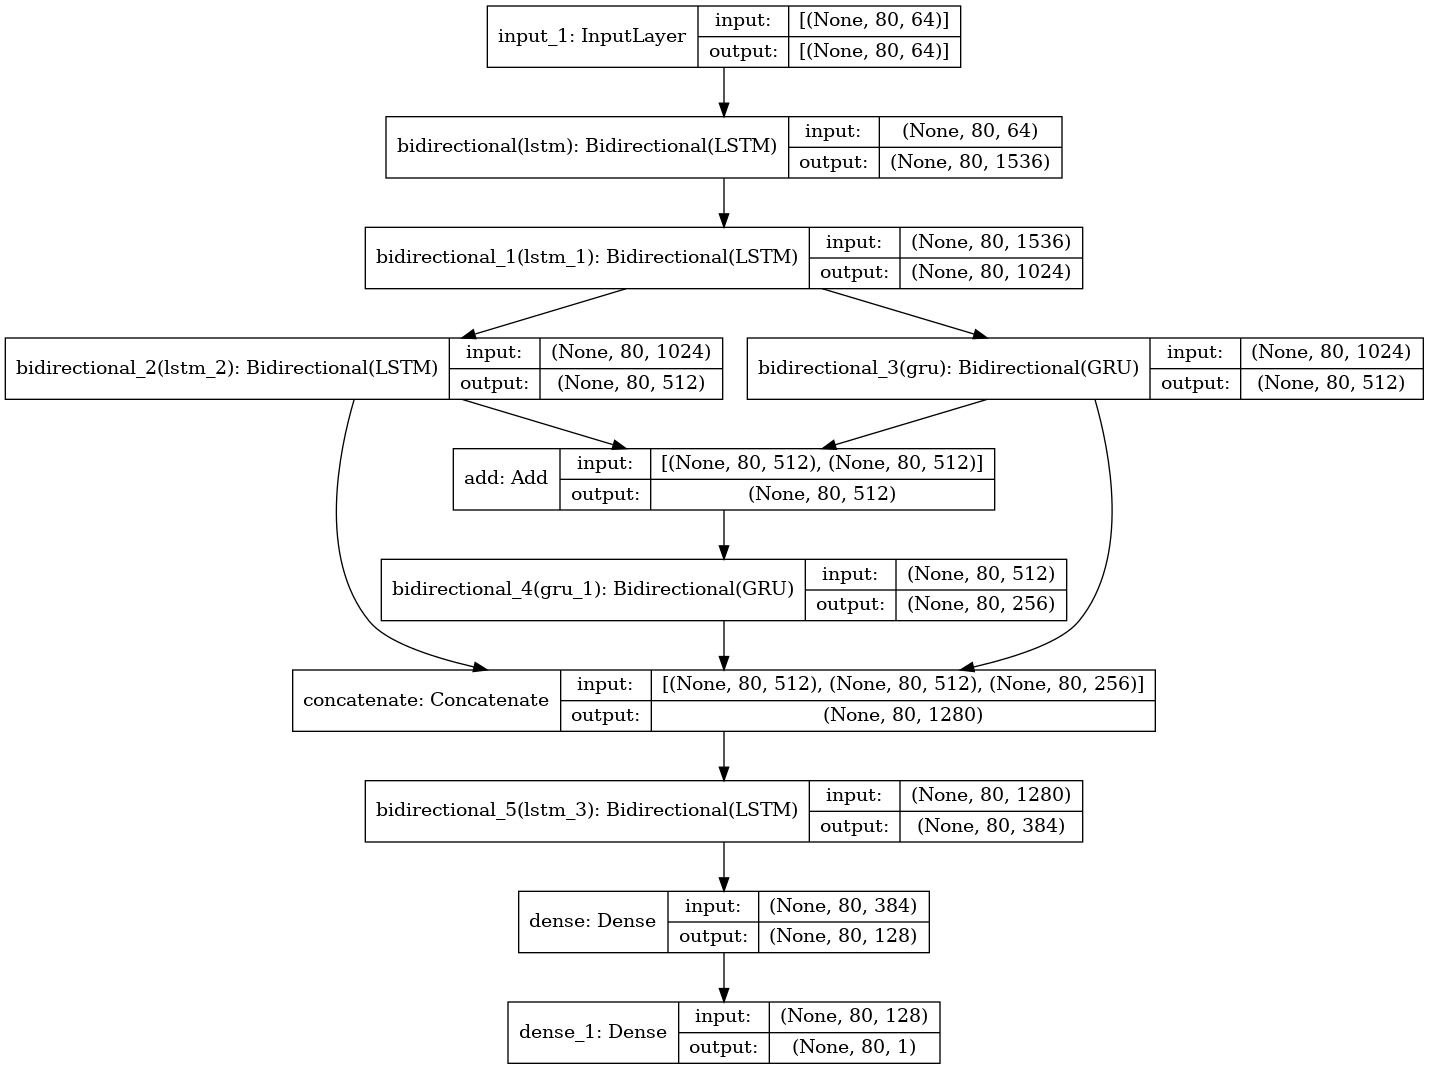

In [ ]:
# ====================================================
# model
# ====================================================
# https://www.kaggle.com/dlaststark/gb-vpp-whoppity-dub-dub/notebook
class CustomModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.dense_dim = cfg.dense_dim #埋め込み特徴量次元
        self.hidden_size = cfg.hidden_size
        self.num_layers = cfg.num_layers
        self.logit_dim = cfg.logit_dim
        
        # nn.Embedding(vocab_size, emb_dim)
        # 1層パーセプトロンのようなもの
        #self.r_emb = nn.Embedding(3, 2, padding_idx=0)
        #self.c_emb = nn.Embedding(3, 2, padding_idx=0)
        self.mlp = nn.Sequential(
            nn.Linear(len(cfg.feature_cols), self.dense_dim // 2),
            nn.LayerNorm(self.dense_dim // 2),
            nn.ReLU(),
            nn.Linear(self.dense_dim // 2, self.dense_dim),
            nn.ReLU(),
        )
        self.lstm1 = nn.LSTM(self.dense_dim, 768,dropout=0., batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(768 * 2, 512,dropout=0., batch_first=True, bidirectional=True)
        self.lstm3 = nn.LSTM(512 * 2, 256,dropout=0., batch_first=True, bidirectional=True)
        
        self.lstm4 = nn.LSTM(512 * 2, 256,dropout=0., batch_first=True, bidirectional=True)
        self.lstm5 = nn.LSTM(512, 128,dropout=0., batch_first=True, bidirectional=True)
        
        self.lstm6 = nn.LSTM(1280, 192,dropout=0., batch_first=True, bidirectional=True)
        
        self.head = nn.Sequential(
            nn.LayerNorm(192* 2),
            nn.ReLU(),
            nn.Linear(192* 2, 1),
        )
        
        self._reinitialize()
        
    def _reinitialize(self):
        """
        Tensorflow/Keras-like initialization
        """
        for name, p in self.named_parameters():
            if 'lstm' in name:
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(p.data)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(p.data)
                elif 'bias_ih' in name:
                    p.data.fill_(0)
                    # Set forget-gate bias to 1
                    n = p.size(0)
                    p.data[(n // 4):(n // 2)].fill_(1)
                elif 'bias_hh' in name:
                    p.data.fill_(0)
            elif 'mlp' in name:
                if 'weight' in name:
                    p = p.reshape(1, -1)
                    nn.init.xavier_uniform_(p.data)
                elif 'bias' in name:
                    p.data.fill_(0)
            elif 'head' in name:
                if 'weight' in name:
                    p = p.reshape(1, -1)
                    nn.init.xavier_uniform_(p.data)
                elif 'bias' in name:
                    p.data.fill_(0)

    def forward(self, x):
        bs = x.size(0)
        features = self.mlp(x) # torch.Size([1024, 80, 512])
        features, _ = self.lstm1(features) # torch.Size([1024, 80, 1536])
        features2, _ = self.lstm2(features) # torch.Size([1024, 80, 1024])
        features3, _ = self.lstm3(features2) # torch.Size([1024, 80, 512])
        
        z2, _ = self.lstm4(features2) # torch.Size([1024, 80, 512])
        z3, _ = self.lstm5(features3 + z2)
        
        x = torch.cat((features3, z2, z3),axis = 2)
        x, _ = self.lstm6(x)
        output = self.head(x).view(bs, -1)
        return output
    
def get_model(cfg):
    model = CustomModel(cfg)
    return model

## exp049

+ kodaさんのノートのモデルをマルマルコピー
    + https://www.kaggle.com/junkoda/pytorch-lstm-with-tensorflow-like-initialization
+ 0.241から0.1817になった
+ 1foldでpublic0.181

In [ ]:
class CustomModel(nn.Module):
    def __init__(self, cfg):
        hidden = [400, 300, 200, 100]
        super().__init__()
        self.cfg = cfg
        self.lstm1 = nn.LSTM(len(cfg.feature_cols), hidden[0],
                             batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(2 * hidden[0], hidden[1],
                             batch_first=True, bidirectional=True)
        self.lstm3 = nn.LSTM(2 * hidden[1], hidden[2],
                             batch_first=True, bidirectional=True)
        self.lstm4 = nn.LSTM(2 * hidden[2], hidden[3],
                             batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(2 * hidden[3], 50)
        self.selu = nn.SELU()
        self.fc2 = nn.Linear(50, 1)
        self._reinitialize()

    def _reinitialize(self):
        """
        Tensorflow/Keras-like initialization
        """
        for name, p in self.named_parameters():
            if 'lstm' in name:
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(p.data)
                elif 'weight_hh' in name:
                    nn.init.orthogonal_(p.data)
                elif 'bias_ih' in name:
                    p.data.fill_(0)
                    # Set forget-gate bias to 1
                    n = p.size(0)
                    p.data[(n // 4):(n // 2)].fill_(1)
                elif 'bias_hh' in name:
                    p.data.fill_(0)
            elif 'fc' in name:
                if 'weight' in name:
                    nn.init.xavier_uniform_(p.data)
                elif 'bias' in name:
                    p.data.fill_(0)

    def forward(self, x):
        bs = x.size(0)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x, _ = self.lstm4(x)
        x = self.fc1(x)
        x = self.selu(x)
        output = self.fc2(x).view(bs, -1)
        #output = self.head(features).view(bs, -1)
        return output
    
def get_model(cfg):
    model = CustomModel(cfg)
    return model